#### Importamos libreiras

In [2]:
import pandas as pd
import numpy as np
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error,f1_score,classification_report
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import pickle

import matplotlib.pyplot as plt

#### Cargar el dataset desde 1 de Enero de 1920 hasta 5 de Marzo de 2023, algo más de 100 años

In [3]:
df = pd.read_csv(r"C:\Users\adria\Desktop\Carpeta pruebas Python\Proyecto_ML\data\processed\aemet_clear.csv",index_col='FECHA')

#### Pasar el index (fecha) como datetime

In [4]:
df.index = pd.to_datetime(df.index)

### Hago la media de temperatura por meses y lo entreno asi ya que a diario no me da buenos resultados

In [5]:
df = df.resample('M').mean()

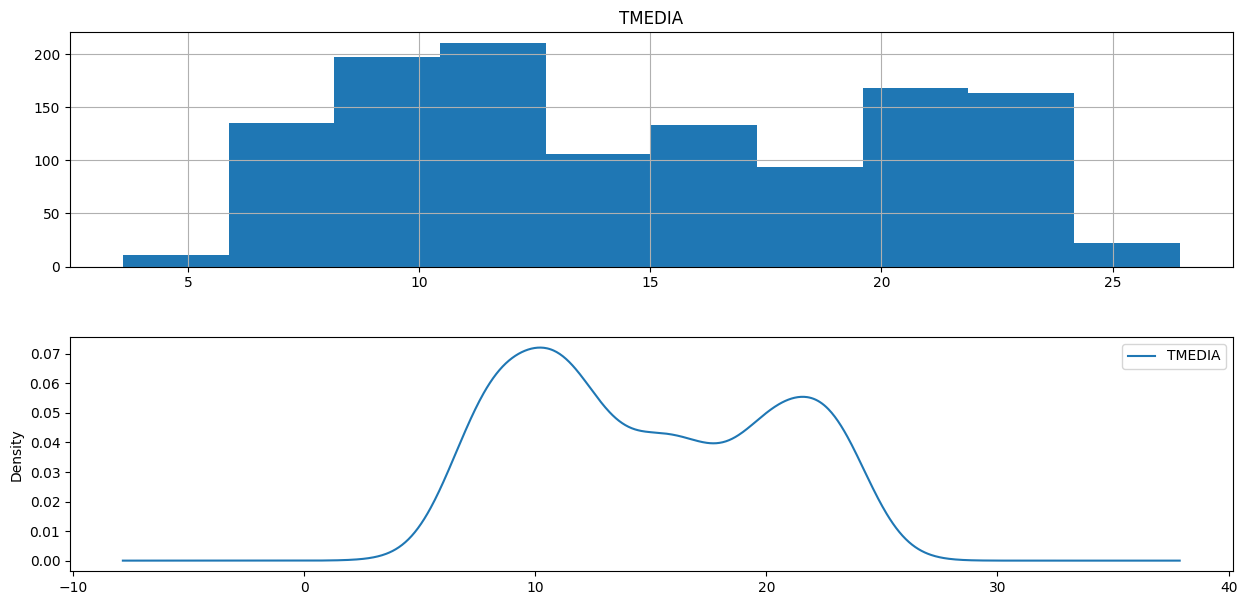

In [6]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, figsize=(15,7))
df.hist(ax=ax1)
df.plot(kind='kde',ax=ax2)
plt.show()

### Descomposición de los datos

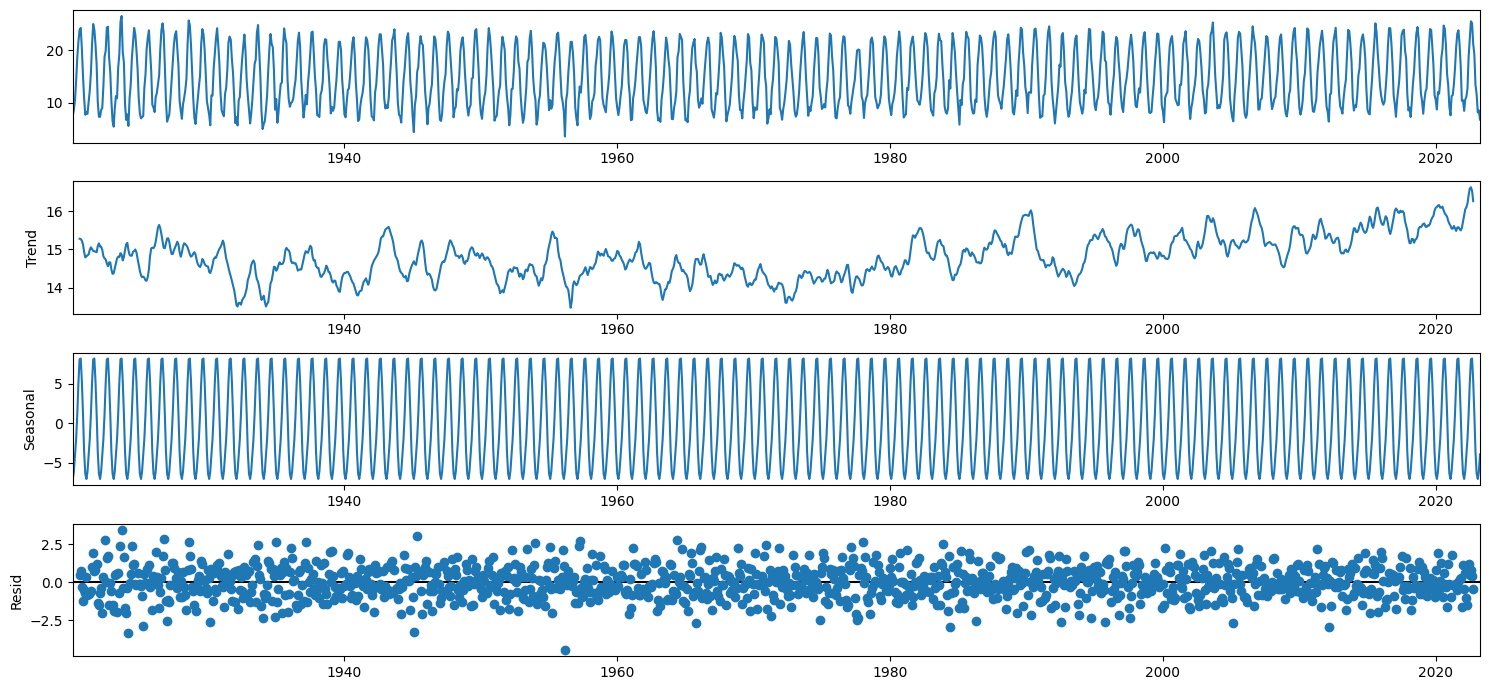

In [7]:
decomposition = seasonal_decompose(df,period=12, model='additive')
plt.rcParams['figure.figsize'] = 15, 7
decomposition.plot()
plt.show()

### Pasar la prueba de Dickey-Fuller

In [8]:
print ('Resultados del test Dickey-Fuller:')
dftest = adfuller(df)

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Resultados del test Dickey-Fuller:
Test Statistic                   -3.044603
p-value                           0.030934
#Lags Used                       23.000000
Number of Observations Used    1215.000000
Critical Value (1%)              -3.435744
Critical Value (5%)              -2.863922
Critical Value (10%)             -2.568038
dtype: float64


### Para que funcione hay que cambiar el indice

In [9]:
df.index = pd.date_range(start='1920-01-01',periods=df.shape[0],freq='M')

### Separar train-test con 24 meses

In [10]:
step = 24
train = df[:-step]
test  = df[-step:]

### Entrenar modelo

In [11]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=2023),
                lags = 15
             )

forecaster.fit(y=train['TMEDIA'])

### Predecir

In [12]:
predicciones = forecaster.predict(steps=step)

### Visualizar lo entrenado a partir de 2017 para que se vea mejor

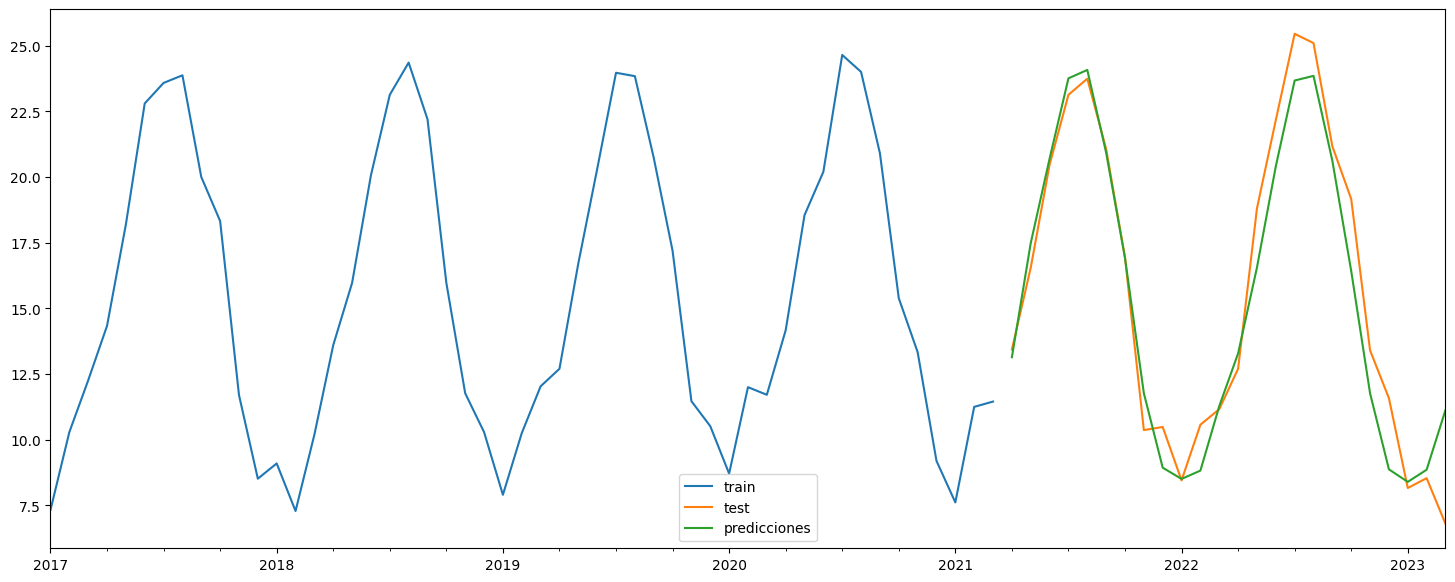

In [13]:
fig, ax = plt.subplots(figsize=(18, 7))
train['TMEDIA'].loc['2017':].plot(ax=ax, label='train')
test['TMEDIA'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

### Métricas

In [14]:
print('r2_score: (%s)'%r2_score(test['TMEDIA'],predicciones))
print('MSE (%s)'%mean_squared_error(test['TMEDIA'],predicciones))
print('RMSE (%s)'%sqrt(mean_squared_error(test['TMEDIA'],predicciones)))

r2_score: (0.9289313757924189)
MSE (2.454649136326105)
RMSE (1.5667319925009844)


### Mi modelo tiene un error de algo más de un grado y medio (RMSE), vamos a probar para los siguentes 2 años

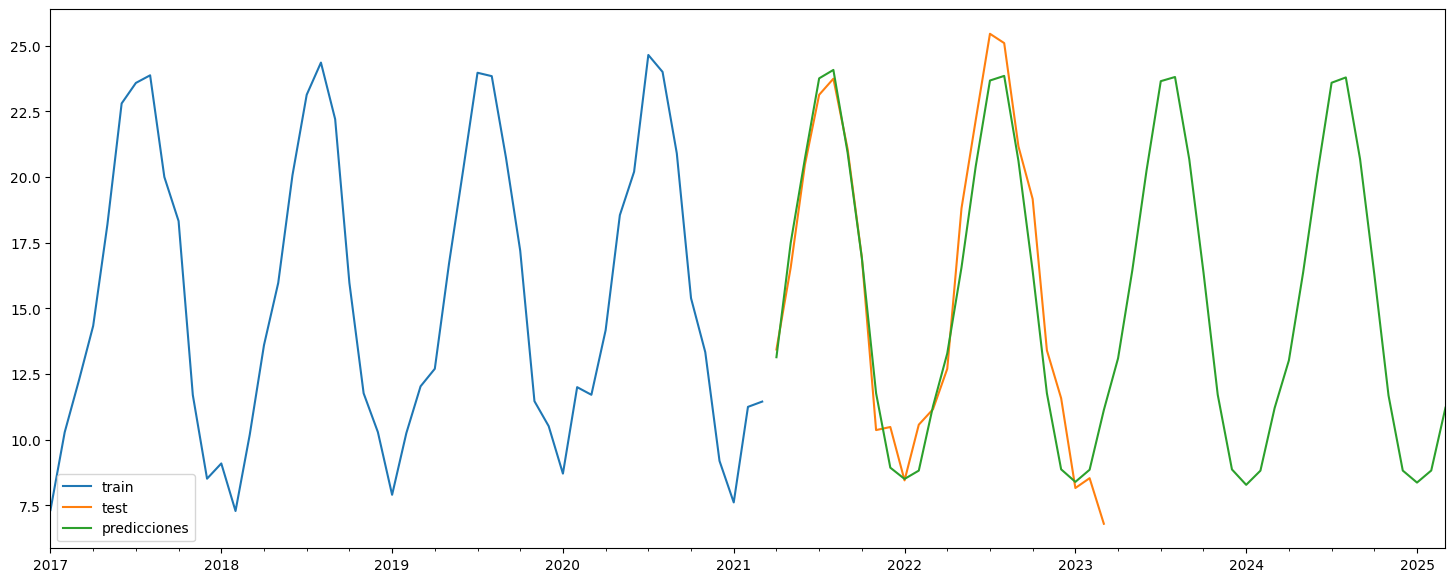

In [15]:
predicciones = forecaster.predict(steps=48)

fig, ax = plt.subplots(figsize=(18, 7))
train['TMEDIA'].loc['2017':].plot(ax=ax, label='train')
test['TMEDIA'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

#### Guardamos el modelo entrenado

In [16]:
#with open(r"C:\Users\adria\Desktop\Carpeta pruebas Python\Proyecto_ML\model\forecaster_2.pickle", "wb") as f:pickle.dump(forecaster, f)

#### Con este comando leemos el archivo guardado anteriormente

In [17]:
#with open(r"C:\Users\adria\Desktop\Mi primer proyecto\Proyecto_ML\model\forecaster_2.pickle", "rb") as f:forecaster_pick = pickle.load(f)
#print(forecaster_pick)